In [1]:
import os.path as osp
import numpy as np
import pathlib
from torch.utils.data import Dataset, DataLoader
import dgl
import torch
from dgl.data.utils import load_graphs, save_graphs


def my_collate(batch):
    graphs, pcs, labels = map(list, zip(*batch))
    labels = torch.stack(labels)
    bg = dgl.batch(graphs)
    pcs = torch.from_numpy(np.stack(pcs)).type(torch.FloatTensor)
    return bg, pcs, labels


class SolidMNISTAutoencoder(Dataset):
    def __init__(self, root_dir, train=True, cached=True):
        """
        Load and create the SolidMNIST dataset
        :param root_dir: Root path to the dataset
        :param train: Whether train or test set
        :param cached: Whether to try loading from cached file
        """
        path = pathlib.Path(root_dir)
        subfolder = "train" if train else "test"
        path /= subfolder
        pointcloud_files = list(path.glob("*.npy"))
        graph_files = list(path.glob("*.bin"))
        print("Found {} {} data.".format(len(graph_files), subfolder))
        print("Found pointcloud {} {} data.".format(len(pointcloud_files), subfolder))
        
        self.pc_hashmap = {}
        for file_name in pointcloud_files:
            query_name = str(file_name).split(".")[0]
            self.pc_hashmap[query_name]  = str(file_name)
        
        self.graph_files = []
        self.pc_files = []
        
        for file_name in graph_files:
            #print(file_name)
            query_name = str(file_name).split(".")[0]
            if query_name not in self.pc_hashmap:
                #print("Error: ", query_name)
                continue 
            self.graph_files.append(str(file_name))
            self.pc_files.append(self.pc_hashmap[query_name])
          
        print("Loaded {} face-adj graphs and {} pc files".format(len(self.graph_files), len(self.pc_files)))

    def __len__(self):
        return len(self.graph_files)

    def __getitem__(self, idx):
        graph_file = str(self.graph_files[idx])
        graphs =  load_graphs(self.graph_files[idx])[0]
        label = graphs[0].ndata['y'][0:1]     
        pointcloud_file = self.pc_files[idx]
        pc = np.load(pointcloud_file)#['arr_0']
        
        return graphs[0], pc, label

In [2]:
#train_dset = SolidMNISTAutoencoder("/raid/data/dataset/SolidMNIST/", train=True, cached=False)

In [3]:
import torch
import torch.nn as nn
import  torch.nn.functional as F
from torch.utils.data import DataLoader
import helper
import os.path as osp
import logging
from torch.optim import lr_scheduler
from torch import distributions as dist
from parse import Parser
import numpy as np
import sklearn.metrics as metrics
from chamfer_distance import ChamferDistance
from networks import nurbs_model
from networks import brep_model
from networks import decoder


chamfer_dist = ChamferDistance()


class Model(nn.Module):
    def __init__(self, args):
        super(Model, self).__init__()
        self.nurbs_feat_ext = nurbs_model.get_nurbs_model(
            args.nurbs_model_type, mask_mode=args.mask_mode, area_as_channel=args.area_as_channel,
            output_dims=args.nurbs_emb_dim)
        self.brep_feat_ext = brep_model.get_brep_model(
            args.brep_model_type, args.nurbs_emb_dim, args.graph_emb_dim)
        self.project_net = nn.Sequential(
                                nn.Linear(args.graph_emb_dim, args.emb_dims),
                                nn.BatchNorm1d(args.emb_dims),
                                nn.ReLU(),
                                nn.Linear(args.emb_dims, args.emb_dims),
                            )
        self.decoder = decoder.get_decoder_model(args.decoder_type, args.num_points, args.emb_dims)   

    def forward(self, bg, feat):
        out  = self.nurbs_feat_ext(feat)
        node_emb, graph_emb = self.brep_feat_ext(bg, out)
        embedding = self.project_net(graph_emb)
        out = self.decoder(embedding)
        return out, embedding


def train_one_epoch(model, loader, optimizer, scheduler, epoch, iteration, args):
    model.train()
    total_loss_array = []
 
    for _, (bg, points, labels) in enumerate(loader):
        iteration = iteration + 1
        optimizer.zero_grad()
    
        feat = bg.ndata['x'].permute(0, 3, 1, 2).to(args.device) 
        points = points.to(args.device) 
        labels = labels.to(args.device).squeeze(-1)
        pred_out, embedding = model(bg, feat)

        # points and points_reconstructed are n_points x 3 matrices
        dist1, dist2 = chamfer_dist(points, pred_out)
        loss = (torch.mean(dist1)) + (torch.mean(dist2))

        loss.backward()
        optimizer.step()
        total_loss_array.append(loss.item())


    scheduler.step()
 
    avg_loss = np.mean(total_loss_array)

    print("[Train] Epoch {:03} iteration {} Chamfer Loss {:2.3f}".format(epoch, iteration, avg_loss.item()*100))
    return avg_loss

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score

def sketch_point_cloud(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], color='dimgray', edgecolors='k', linewidths=0.5, zdir='x')
    #plt.axis('off')
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-0.8, 0.8])
    ax.set_zlim([-0.8, 0.8])
    ax.axis("off")
    ax.grid(False)
    plt.show()
    
def visulaization(model, loader, epoch, iteration, args):
    model.eval()
    bg, points, labels = next(iter(loader))
    feat = bg.ndata['x'].permute(0, 3, 1, 2).to(args.device) 
    points = points.to(args.device) 
    labels = labels.to(args.device).squeeze(-1)
    pred_out, embedding = model(bg, feat)
    #print(pred_out.shape, points.shape)
    sketch_point_cloud(pred_out[0].detach().cpu().numpy())
    sketch_point_cloud(points[0].detach().cpu().numpy())
    pass



In [4]:
def cluster(model, loader, epoch, iteration, args):
    model.eval()
    
    embeddings = []
    labels = []
    with torch.no_grad():
        for _, (bg, points, label) in enumerate(loader):
            feat = bg.ndata['x'].permute(0, 3, 1, 2).to(args.device) 
            points = points.to(args.device) 
            label = label.to(args.device).squeeze(-1)
            pred_out, embedding = model(bg, feat)
            embeddings.append(embedding.detach().cpu().numpy())
            labels.append(label.detach().cpu().numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    print(labels)
    kmeans = KMeans(init='k-means++', n_clusters=13, n_init=100)
    kmeans.fit(embeddings)
    pred_labels = kmeans.labels_
    print(pred_labels)
    score = adjusted_mutual_info_score(labels, pred_labels)
    print("NMI score on training data {}".format(score))
    return score
    

In [5]:
import argparse
args = argparse.Namespace()
args.brep_model_type="gin"
args.classifier_type="linear"
args.nurbs_model_type="cnn" 
args.decoder_type="point_decoder" 
args.batch_size= 32
args.dataset_path="/raid/data/dataset/SolidMNIST/"
args.in_channels=7
args.graph_emb_dim= 128
args.emb_dims= 1024
args.device=0
args.num_layers=5
args.num_mlp_layers=2
args.hidden_dim=64
args.nurbs_emb_dim = 64
args.num_points = 1024
args.optimizer = 'Adam'
args.lr = 0.0001
args.epochs = 5000
args.mask_mode = "channel"
args.area_as_channel = True

In [6]:
def experiment_name(args, use_timestamp: bool = False, suffix='') -> str:
    """
    Create a name for the experiment from the command line arguments to the script
    :param args: Arguments parsed by argparse
    :param suffix: Suffix string to append to experiment name
    :return: Experiment name as a string
    """
    from datetime import datetime
    tokens = ["AutoPC", args.brep_model_type, args.nurbs_model_type,
               args.graph_emb_dim, args.nurbs_emb_dim]
    if use_timestamp:
        timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        tokens.append(timestamp)
    if len(suffix) > 0:
        tokens.append(suffix)
    return "_".join(map(str, tokens))



In [7]:
print('show all arguments configuration...')
print(args)
device = "cuda:" + str(args.device)
args.device = device 

exp_name = experiment_name(args)

# Create directories for checkpoints and logging
log_filename = osp.join('dump', exp_name, 'log.txt')
checkpoint_dir = osp.join('dump', exp_name, 'checkpoints')
img_dir = osp.join('dump', exp_name, 'imgs')
helper.create_dir(checkpoint_dir)
helper.create_dir(img_dir)
print("Experiment name: {}".format(exp_name))


# train_loader = helper.get_dataloader(args, args.batch_size, train=True)
# val_loader = helper.get_dataloader(args, args.batch_size, train=False)

#train_dset = SolidMNISTAutoencoder("/raid/data/dataset/SolidMNIST/", train=True, cached=False)
train_dset = SolidMNISTAutoencoder("/raid/data/dataset/SolidMNIST/", train=True, cached=False)
train_loader = DataLoader(train_dset, batch_size=args.batch_size, collate_fn=my_collate,
                    pin_memory=True, shuffle=True)
val_dset = SolidMNISTAutoencoder("/raid/data/dataset/SolidMNIST/", train=False, cached=False)
val_loader = DataLoader(val_dset, batch_size=args.batch_size, collate_fn=my_collate,
                    pin_memory=True, shuffle=True)

model = Model(args).to(device)

optimizer = helper.get_optimizer(args.optimizer, model, lr=args.lr)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, 0.000001)

iteration  = 0 
best_loss = float("inf")
best_acc = 0

show all arguments configuration...
Namespace(area_as_channel=True, batch_size=32, brep_model_type='gin', classifier_type='linear', dataset_path='/raid/data/dataset/SolidMNIST/', decoder_type='point_decoder', device=0, emb_dims=1024, epochs=5000, graph_emb_dim=128, hidden_dim=64, in_channels=7, lr=0.0001, mask_mode='channel', num_layers=5, num_mlp_layers=2, num_points=1024, nurbs_emb_dim=64, nurbs_model_type='cnn', optimizer='Adam')
Experiment name: AutoPC_gin_cnn_128_64
Found 82870 train data.
Found pointcloud 82712 train data.
Loaded 82710 face-adj graphs and 82710 pc files
Found 18678 test data.
Found pointcloud 18677 test data.
Loaded 18677 face-adj graphs and 18677 pc files


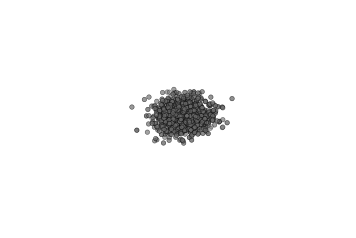

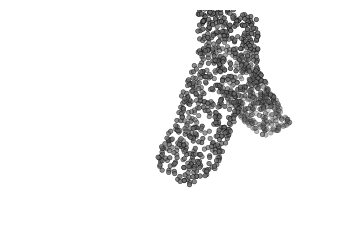

[ 8  0 11 ...  2 12 12]
[0 0 0 ... 0 0 0]
NMI score on training data 0.01414040769135752


KeyboardInterrupt: 

In [8]:
iteration = 0
best_loss = float("inf")
best_acc = 0
visualize_every = 5

for epoch in range(1, args.epochs + 1):
    if epoch % visualize_every == True: 
        visulaization(model, val_loader, epoch, iteration, args)
        cluster(model, val_loader, epoch, iteration, args)
    tloss = train_one_epoch(model, train_loader, optimizer, scheduler, epoch, iteration, args)
    

In [ ]:

# import os.path as osp
# import numpy as np
# import pathlib
# from torch.utils.data import Dataset, DataLoader
# import dgl
# import torch
# from dgl.data.utils import load_graphs, save_graphs


# def my_collate(batch):
#     graphs, pcs, labels = map(list, zip(*batch))
#     labels = torch.stack(labels)
#     bg = dgl.batch(graphs)
#     pcs = torch.from_numpy(np.stack(pcs)).type(torch.FloatTensor)
#     return bg, pcs, labels


# def read_feat(filename: str):
#     """
#     Load face-adjacency graph from given .feat file
#     :param filename .feat filename
#     """
#     # Read all lines
#     lines = None
#     with open(filename) as f:
#         lines = f.readlines()

#     # Header
#     num_faces = 0
#     num_u = 0
#     num_v = 0
#     num_edges = 0

#     # Find and parse header
#     start_line = 0
#     for i, line in enumerate(lines):
#         if line.startswith("#"):
#             continue
#         num_faces, num_u, num_v, num_edges = map(int, line.strip().split(" "))
#         start_line = i + 1  # Start line index in file for face features
#         break
#     # End line index in file for face features
#     end_line = start_line + num_faces * num_u * num_v
#     node_feat = np.array([[float(x) for x in row.strip().split(" ")]
#                           for row in lines[start_line:end_line]], dtype=np.float32)
#     node_feat = node_feat.reshape((num_faces, num_u, num_v, 10))
#     adj_list = np.array([[int(x) for x in row.strip().split(" ")]
#                          for row in lines[end_line:]], dtype=np.int)
#     return node_feat, adj_list


# def _make_dgl_graph(xs, edges, label):
#     g = dgl.DGLGraph()
#     g.add_nodes(xs.shape[0])
#     g.ndata['x'] = torch.tensor(xs).float()
#     g.add_edges(edges[:, 0], edges[:, 1])
#     g.ndata['y'] = (torch.ones(xs.shape[0]) * label).long()
#     return g


# class SolidMNISTAutoencoder(Dataset):
#     def __init__(self, root_dir, train=True, cached=True):
#         """
#         Load and create the SolidMNIST dataset
#         :param root_dir: Root path to the dataset
#         :param train: Whether train or test set
#         :param cached: Whether to try loading from cached file
#         """
#         path = pathlib.Path(root_dir)
#         subfolder = "train" if train else "test"
#         cache_file = str((path / (subfolder + ".bin")).absolute())
#         if cached and osp.exists(cache_file):
#             print("Loading from cache:", cache_file)
#             path /= subfolder
#             self.graphs = load_graphs(cache_file)[0]
#             pointcloud_files = list(path.glob("*.npy"))
#             self.num_classes = 0
#             for g in self.graphs:
#                 self.num_classes = max(self.num_classes, int(g.ndata['y'][0].item() + 1))
#         else:
#             if cached:
#                 print("Cache file not found... regenerating")
#             path /= subfolder
#             feat_files = list(path.glob("*.bin"))
#             pointcloud_files = list(path.glob("*.npy"))
#             print("Found {} {} data.".format(len(feat_files), subfolder))
#             print("Found pointcloud {} {} data.".format(len(pointcloud_files), subfolder))
#             assert len(feat_files) > 0
#             self.graphs = []
#             label_count = 0
#             label2idx = {}
#             for fidx, fn in enumerate(zip(feat_files)):
#                 if fidx % 100 == 0:
#                     print("Loading {} / {} ...".format(fidx, len(feat_files)))
#                 # the first character of filename must be the alphabet
#                 label = fn.stem[0].lower()
                
#                 xs, edges = read_feat(fn)
#                 if label not in label2idx:
#                     label2idx[label] = label_count
#                     label_count += 1
#                 self.graphs.append(_make_dgl_graph(
#                     xs, edges, label2idx.get(label)))
#             self.num_classes = len(label2idx)
#             print("Caching graphs to:", cache_file)
#             save_graphs(cache_file, self.graphs)
#         self.pc_files = pointcloud_files
#         print("Loaded {} face-adj graphs with {} classes and {} pc files".format(len(self.graphs), self.num_classes, len(self.pc_files)))

#     def __len__(self):
#         return len(self.graphs)

#     def __getitem__(self, idx):
#         label = self.graphs[idx].ndata['y'][0:1]
#         #print(self.pc_files)
#         pointcloud_file = self.pc_files[idx]
#         pc = np.load(pointcloud_file)
#         return self.graphs[idx], pc, label


# def _save_feature_to_csv(feat: torch.Tensor, filename):
#     """
#     Save loaded feature to csv file to visualize sampled points
#     :param feat Features loaded from *.feat file of shape [#faces, #u, #v, 10]
#     :param filename Output csv filename
#     """
#     assert len(feat.shape) == 4  # faces x #u x #v x 10
#     pts = feat[:, :, :, :3].numpy().reshape((-1, 3))
#     mask = feat[:, :, :, 6].numpy().reshape(-1)
#     point_indices_inside_faces = (mask == 1)
#     pts = pts[point_indices_inside_faces, :]
#     np.savetxt(filename, pts, delimiter=",", header="x,y,z")

